In [27]:
# import libraries
import pandas as pd
import numpy as np

In [28]:
# import prube libraries
import geopandas as gpd

import folium
from folium import plugins # sirve para hacer mapas interactivos

# import matplotlib
# import matplotlib as mpl
import matplotlib.pyplot as plt # superior en cuestion de rendimiento
import seaborn as sns
# %matplotlib inline

import json
import pydeck as pdk # for 3D maps, buen resultado, muy visual


from shapely.geometry import LineString, Point

In [29]:
# Variables globales
latitud = 41.155
longitud = -8.63
zoom = 13
nrows = 100000
# Ruta del archivo CSV
filename = "../train_data/taxis_trajectory/train.csv"

In [30]:
def load_and_simplify_data(filename, rows, tolerance=0.001):
    # Cargar datos
    df = pd.read_csv(filename, nrows=rows, sep=",", low_memory=False)
    
    # Filtrar polilíneas vacías o con un solo punto
    def create_line(x):
        points = json.loads(x)
        if len(points) > 1:
            return LineString(points)
        return None

    df['geometry'] = df['POLYLINE'].apply(create_line)
    
    # Eliminar filas con geometrías nulas
    df = df[df['geometry'].notnull()]
    
    # Convertir a Geopandas DataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Simplificar las geometrías
    gdf['geometry'] = gdf['geometry'].simplify(tolerance)
    
    return gdf


In [31]:
# Cargar y simplificar datos
gdf = load_and_simplify_data(filename, nrows)
gdf.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,geometry
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","LINESTRING (-8.61864 41.14141, -8.63275 41.146..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","LINESTRING (-8.63985 41.15983, -8.67085 41.165..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...","LINESTRING (-8.61296 41.14036, -8.61421 41.140..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","LINESTRING (-8.57468 41.15195, -8.58074 41.145..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","LINESTRING (-8.64599 41.18049, -8.64680 41.178..."


In [32]:
""" # Resto del código...
def plot_polylines_on_map(gdf, start_location, map_zoom_start=12):
    # Crear un mapa base
    m = folium.Map(location=start_location, zoom_start=map_zoom_start)

    # Añadir las polilíneas al mapa
    for _, row in gdf.iterrows():
        polyline = row['geometry'].coords[:]
        folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)

    return m """

" # Resto del código...\ndef plot_polylines_on_map(gdf, start_location, map_zoom_start=12):\n    # Crear un mapa base\n    m = folium.Map(location=start_location, zoom_start=map_zoom_start)\n\n    # Añadir las polilíneas al mapa\n    for _, row in gdf.iterrows():\n        polyline = row['geometry'].coords[:]\n        folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)\n\n    return m "

In [33]:
# Prueva mapa segmetado con columna adicional

""" # Definir una ubicación inicial para centrar el mapa (modifica con tus coordenadas)
start_location = [41.155, -8.63]

# Crear y mostrar el mapa
m = plot_polylines_on_map(gdf, start_location)
m """

' # Definir una ubicación inicial para centrar el mapa (modifica con tus coordenadas)\nstart_location = [41.155, -8.63]\n\n# Crear y mostrar el mapa\nm = plot_polylines_on_map(gdf, start_location)\nm '

In [34]:
# Prueva mapa segmetado sin columna adicional

""" # Crear un mapa base
m = folium.Map(location=[latitud, longitud], zoom_start=zoom)

# Añadir las polilíneas
for _, row in gdf.iterrows():
    polyline = json.loads(row['POLYLINE'])
    folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)

# mostrar el mapa
m """

" # Crear un mapa base\nm = folium.Map(location=[latitud, longitud], zoom_start=zoom)\n\n# Añadir las polilíneas\nfor _, row in gdf.iterrows():\n    polyline = json.loads(row['POLYLINE'])\n    folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)\n\n# mostrar el mapa\nm "

In [35]:
# Verificar el formato actual de 'POLYLINE'
""" gdf['POLYLINE'] = gdf['POLYLINE'].apply(json.loads)
print(gdf['POLYLINE'].head()) """

" gdf['POLYLINE'] = gdf['POLYLINE'].apply(json.loads)\nprint(gdf['POLYLINE'].head()) "

In [36]:
# Intento de suabizar las polilineas

""" def chaikin_smoothing(points, iterations=2):
    # Aplica el algoritmo de suavizado de Chaikin a una serie de puntos.
    if len(points) < 3:
        return points  # No se puede suavizar si hay menos de 3 puntos

    for _ in range(iterations):
        new_points = [points[0]]  # El primer punto siempre se mantiene
        for i in range(len(points) - 1):
            p0 = points[i]
            p1 = points[i + 1]
            q = [0.75 * p0[0] + 0.25 * p1[0], 0.75 * p0[1] + 0.25 * p1[1]]
            r = [0.25 * p0[0] + 0.75 * p1[0], 0.25 * p0[1] + 0.75 * p1[1]]
            new_points.extend([q, r])
        new_points.append(points[-1])  # El último punto siempre se mantiene
        points = new_points

    return points

# Aplicar el suavizado a cada polilínea
gdf['SMOOTHED_POLYLINE'] = gdf['POLYLINE'].apply(chaikin_smoothing) """

" def chaikin_smoothing(points, iterations=2):\n    # Aplica el algoritmo de suavizado de Chaikin a una serie de puntos.\n    if len(points) < 3:\n        return points  # No se puede suavizar si hay menos de 3 puntos\n\n    for _ in range(iterations):\n        new_points = [points[0]]  # El primer punto siempre se mantiene\n        for i in range(len(points) - 1):\n            p0 = points[i]\n            p1 = points[i + 1]\n            q = [0.75 * p0[0] + 0.25 * p1[0], 0.75 * p0[1] + 0.25 * p1[1]]\n            r = [0.25 * p0[0] + 0.75 * p1[0], 0.25 * p0[1] + 0.75 * p1[1]]\n            new_points.extend([q, r])\n        new_points.append(points[-1])  # El último punto siempre se mantiene\n        points = new_points\n\n    return points\n\n# Aplicar el suavizado a cada polilínea\ngdf['SMOOTHED_POLYLINE'] = gdf['POLYLINE'].apply(chaikin_smoothing) "

In [37]:
# Prueva de pydeck

# Transformar cada línea en un diccionario
""" lines_data = [{"path": polyline, "color": [255, 0, 0]} for polyline in gdf['POLYLINE']]
lines_df = pd.DataFrame(lines_data)

# Configurar la vista inicial
view_state = pdk.ViewState(latitude=latitud, longitude=longitud, zoom=zoom)

# Crear la capa de líneas
layer = pdk.Layer(
    type="PathLayer",
    data=lines_df,
    get_path="path",
    get_color="color",
    width_min_pixels=2.5,
    pickable=True
)

# Renderizar el mapa
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show() """

' lines_data = [{"path": polyline, "color": [255, 0, 0]} for polyline in gdf[\'POLYLINE\']]\nlines_df = pd.DataFrame(lines_data)\n\n# Configurar la vista inicial\nview_state = pdk.ViewState(latitude=latitud, longitude=longitud, zoom=zoom)\n\n# Crear la capa de líneas\nlayer = pdk.Layer(\n    type="PathLayer",\n    data=lines_df,\n    get_path="path",\n    get_color="color",\n    width_min_pixels=2.5,\n    pickable=True\n)\n\n# Renderizar el mapa\nr = pdk.Deck(layers=[layer], initial_view_state=view_state)\nr.show() '

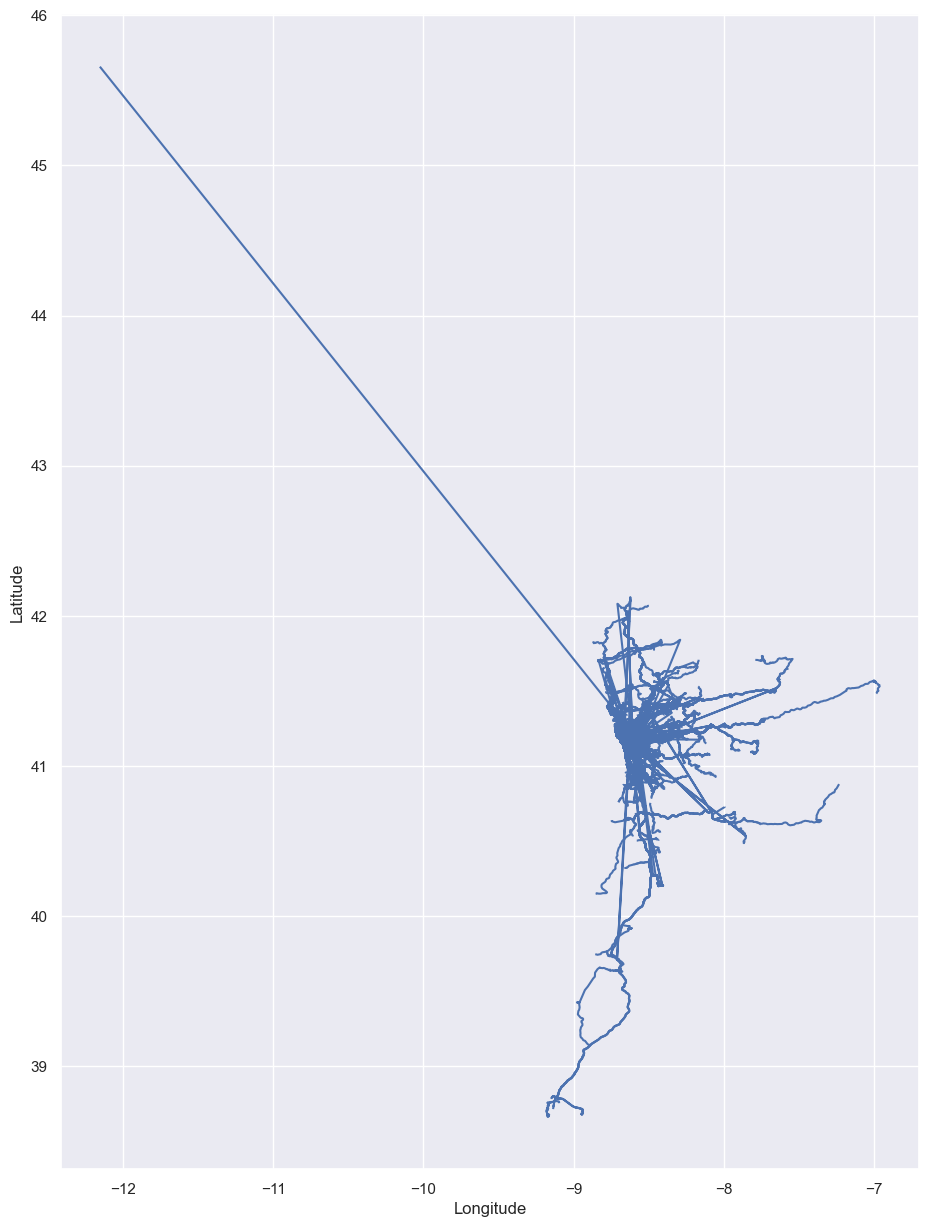

<Figure size 1500x800 with 0 Axes>

In [38]:
# Prueva geopamdas ,matplotlib y seaborn

# Configurar el tamaño de la figura con Matplotlib
plt.rcParams['figure.figsize'] = [15, 8]

# Configurar el estilo de los gráficos con Seaborn
sns.set(style="darkgrid")

# Dibujar el gráfico
# Si tu GeoDataFrame tiene una columna 'geometry', la usamos directamente
gdf.plot(figsize=[15, 15])

# Configurar las etiquetas de los ejes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar el gráfico
plt.show()

plt.savefig("mapa_visualizacion.png", bbox_inches='tight')


In [39]:
import folium

# Crear un mapa base
m = folium.Map(location=[41.155, -8.63], zoom_start=12)  # Ajusta esto según tus necesidades

In [40]:
from folium import IFrame
import base64

# Codificar la imagen para incrustarla
encoded = base64.b64encode(open("mapa_visualizacion.png", 'rb').read()).decode()

# Crear un iFrame con la imagen
iframe = IFrame(encoded, width=700, height=400)
popup = folium.Popup(iframe, max_width=700)

# Crear un marcador con la imagen incrustada
marker = folium.Marker([41.155, -8.63], popup=popup)  # Ajusta la ubicación según tus necesidades

# Añadir el marcador al mapa
marker.add_to(m)

# Mostrar el mapa
m